<a href="https://colab.research.google.com/github/VerbVal/ML_course_yandex/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%2202_hw_fmnist_classification_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание №1
## Часть2: Классификация FashionMNIST
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/s/rads_ai

В данном задании вам предстоит решить достаточно простую задачу классификации изображений с помощью сверточных нейронных сетей.

In [1]:
# do not change the code in the block below
# __________start of block__________
import json
import os
import re

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST

# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score


# __________end of block__________

Загрузите файл `hw_overfitting_data_dict.npy` (ссылка есть на странице с заданием), он понадобится для генерации посылок. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).


In [3]:
!wget https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict -O hw_overfitting_data_dict.npy

--2025-09-14 19:17:19--  https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict [following]
--2025-09-14 19:17:19--  https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272446 (6.0M) [application/octet-stream]
Saving to: ‘hw_overfitting_data_dict.npy’

hw_overfitting_data 100%[===================>]   5.98M  --.-KB/s 

In [4]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

# __________end of block__________

Вернемся к задаче распознавания простых изображений, рассмотренной ранее. Но теперь будем работать с набором данных [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). В данном задании воспользуемся всем датасетом целиком.

__Ваша первая задача: реализовать весь пайплан обучения модели и добиться качества $\geq 88.5\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбукам с предыдущих занятий.

In [5]:
CUDA_DEVICE_ID = 0  # change if needed

In [6]:
# do not change the code in the block below
# __________start of block__________
device = (
    torch.device(f"cuda:{CUDA_DEVICE_ID}") if torch.cuda.is_available() else torch.device("cpu")
)
# __________end of block__________

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 302kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.60MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.3MB/s]


Text(0.5, 1.0, 'Image label: 1')

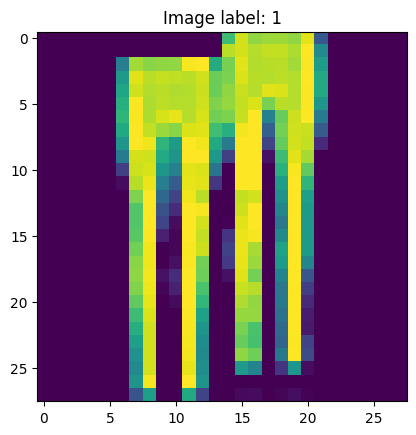

In [7]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 88.5% accuracy.

__Внимание, ваша модель должна быть представлена именно переменной `model_task_1`. На вход ей должен приходить тензор размерностью (1, 28, 28).__

In [8]:
# Creating model instance
model_task_1 = None
# your code here
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # Первый слой
        self.fc2 = nn.Linear(128, 64)        # Второй слой
        self.fc3 = nn.Linear(64, 32)         # Третий слой
        self.fc4 = nn.Linear(32, 10)         # Четвертый слой (выходной)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Преобразование размера входного тензора
        x = F.relu(self.fc1(x))  # Применение ReLU активации
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)          # Выходной слой без активации (логиты)
        return x

# Создание экземпляра модели и перенос на устройство
model_task_1 = SimpleNN().to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_task_1.parameters(), lr=0.001)

# Функция для обучения модели
def train_model(model, data_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for batch in data_loader:
            images, labels = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()              # Обнуление градиентов
            outputs = model(images)            # Прямой проход
            loss = criterion(outputs, labels)  # Вычисление потерь
            loss.backward()                    # Обратный проход
            optimizer.step()                   # Обновление весов

# Обучение модели
train_model(model_task_1, train_data_loader, criterion, optimizer, epochs=5)

# Функция для получения точности модели
def get_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Оценка модели на тестовой выборке
test_accuracy = get_accuracy(model_task_1, test_data_loader)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 86.56%


In [9]:
# Определение модели с улучшенной архитектурой
class ImprovedNN(nn.Module):
    def __init__(self):
        super(ImprovedNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)  # Увеличение числа нейронов
        self.dropout1 = nn.Dropout(0.3)      # Dropout для предотвращения переобучения
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)                # Применение Dropout
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)                # Применение Dropout
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Создание экземпляра модели и перенос на устройство
model_task_1 = ImprovedNN().to(device)

# Определение функции потерь и оптимизатора с измененным learning rate
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_task_1.parameters(), lr=0.0005)  # Уменьшенный learning rate

# Функция для обучения модели
def train_model(model, data_loader, criterion, optimizer, epochs=10):  # Увеличено количество эпох
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch in data_loader:
            images, labels = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(data_loader):.4f}')

# Обучение модели
train_model(model_task_1, train_data_loader, criterion, optimizer, epochs=10)

# Функция для получения точности модели
def get_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Оценка модели на тестовой выборке
test_accuracy = get_accuracy(model_task_1, test_data_loader)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch [1/10], Loss: 0.6299
Epoch [2/10], Loss: 0.4294
Epoch [3/10], Loss: 0.3889
Epoch [4/10], Loss: 0.3672
Epoch [5/10], Loss: 0.3496
Epoch [6/10], Loss: 0.3349
Epoch [7/10], Loss: 0.3250
Epoch [8/10], Loss: 0.3156
Epoch [9/10], Loss: 0.3102
Epoch [10/10], Loss: 0.2980
Test Accuracy: 87.94%


In [10]:
# Определение модели с улучшенной архитектурой
class ImprovedNN(nn.Module):
    def __init__(self):
        super(ImprovedNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)  # Увеличение числа нейронов
        self.dropout1 = nn.Dropout(0.3)      # Dropout для предотвращения переобучения
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)                # Применение Dropout
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)                # Применение Dropout
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Создание экземпляра модели и перенос на устройство
model_task_1 = ImprovedNN().to(device)

# Определение функции потерь и оптимизатора с L2-регуляризацией
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_task_1.parameters(), lr=0.0005, weight_decay=1e-5)  # Добавлена L2-регуляризация

# Функция для обучения модели
def train_model(model, data_loader, criterion, optimizer, epochs=20):  # Увеличено количество эпох
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch in data_loader:
            images, labels = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(data_loader):.4f}')

# Обучение модели
train_model(model_task_1, train_data_loader, criterion, optimizer, epochs=20)

# Функция для получения точности модели
def get_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Оценка модели на тестовой выборке
test_accuracy = get_accuracy(model_task_1, test_data_loader)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Epoch [1/20], Loss: 0.5677
Epoch [2/20], Loss: 0.4085
Epoch [3/20], Loss: 0.3711
Epoch [4/20], Loss: 0.3488
Epoch [5/20], Loss: 0.3323
Epoch [6/20], Loss: 0.3178
Epoch [7/20], Loss: 0.3101
Epoch [8/20], Loss: 0.2981
Epoch [9/20], Loss: 0.2889
Epoch [10/20], Loss: 0.2842
Epoch [11/20], Loss: 0.2770
Epoch [12/20], Loss: 0.2688
Epoch [13/20], Loss: 0.2639
Epoch [14/20], Loss: 0.2581
Epoch [15/20], Loss: 0.2530
Epoch [16/20], Loss: 0.2487
Epoch [17/20], Loss: 0.2434
Epoch [18/20], Loss: 0.2421
Epoch [19/20], Loss: 0.2369
Epoch [20/20], Loss: 0.2328
Test Accuracy: 89.32%


Не забудьте перенести модель на выбранный `device`!

In [11]:
model_task_1.to(device)

ImprovedNN(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)

Локальные тесты для проверки вашей модели доступны ниже:

In [12]:
# do not change the code in the block below
# __________start of block__________
assert model_task_1 is not None, "Please, use `model_task_1` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model_task_1(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Также рекомендуем поработать с `learning rate`.

In [13]:
# your code here
# Определение модели с измененной архитектурой
class ImprovedNN(nn.Module):
    def __init__(self):
        super(ImprovedNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)  # Увеличение числа нейронов
        self.fc2 = nn.Linear(256, 128)       # Увеличение числа нейронов
        self.fc3 = nn.Linear(128, 64)        # Увеличение числа нейронов
        self.fc4 = nn.Linear(64, 10)         # Выходной слой

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Преобразование размера входного тензора
        x = F.relu(self.fc1(x))  # Применение ReLU активации
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)          # Выходной слой без активации (логиты)
        return x

# Создание экземпляра модели и перенос на устройство
model_task_2 = ImprovedNN().to(device)

# Определение функции потерь и оптимизатора с измененным learning rate
learning_rate = 0.0005  # Попробуем меньший learning rate
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_task_2.parameters(), lr=learning_rate)

# Функция для обучения модели с выводом потерь на каждой эпохе
def train_model(model, data_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch in data_loader:
            images, labels = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()              # Обнуление градиентов
            outputs = model(images)            # Прямой проход
            loss = criterion(outputs, labels)  # Вычисление потерь
            loss.backward()                    # Обратный проход
            optimizer.step()                   # Обновление весов

            running_loss += loss.item()

        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(data_loader):.4f}')

# Обучение модели
train_model(model_task_2, train_data_loader, criterion, optimizer, epochs=10)

# Функция для получения точности модели
def get_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Оценка модели на тестовой выборке
test_accuracy = get_accuracy(model_task_2, test_data_loader)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch [1/10], Loss: 0.5596
Epoch [2/10], Loss: 0.3830
Epoch [3/10], Loss: 0.3409
Epoch [4/10], Loss: 0.3151
Epoch [5/10], Loss: 0.2943
Epoch [6/10], Loss: 0.2822
Epoch [7/10], Loss: 0.2664
Epoch [8/10], Loss: 0.2545
Epoch [9/10], Loss: 0.2428
Epoch [10/10], Loss: 0.2320
Test Accuracy: 88.77%


In [24]:
# Определение модели с улучшенной архитектурой
class ImprovedNN(nn.Module):
    def __init__(self):
        super(ImprovedNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)  # Увеличение числа нейронов
        self.dropout1 = nn.Dropout(0.3)      # Dropout для предотвращения переобучения
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)                # Применение Dropout
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)                # Применение Dropout
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Создание экземпляра модели и перенос на устройство
model_task_1 = ImprovedNN().to(device)

# Определение функции потерь и оптимизатора с L2-регуляризацией
criterion = nn.CrossEntropyLoss()
initial_lr = 0.001  # Начальный learning rate
optimizer = torch.optim.AdamW(model_task_1.parameters(), lr=initial_lr, weight_decay=1e-5)  # Добавлена L2-регуляризация

# Использование ReduceLROnPlateau для динамического изменения learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

# Функция для обучения модели
def train_model(model, data_loader, criterion, optimizer, scheduler, epochs=20):  # Увеличено количество эпох
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch in data_loader:
            images, labels = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(data_loader)
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}')

        # Обновление learning rate на основе потерь
        scheduler.step(avg_loss)

# Обучение модели
train_model(model_task_1, train_data_loader, criterion, optimizer, scheduler, epochs=20)

# Функция для получения точности модели
def get_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
      for batch in data_loader:
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Оценка модели на тестовой выборке
test_accuracy = get_accuracy(model_task_1, test_data_loader)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch [1/20], Loss: 0.5626
Epoch [2/20], Loss: 0.4158
Epoch [3/20], Loss: 0.3879
Epoch [4/20], Loss: 0.3643
Epoch [5/20], Loss: 0.3491
Epoch [6/20], Loss: 0.3375
Epoch [7/20], Loss: 0.3288
Epoch [8/20], Loss: 0.3208
Epoch [9/20], Loss: 0.3132
Epoch [10/20], Loss: 0.3066
Epoch [11/20], Loss: 0.3008
Epoch [12/20], Loss: 0.2963
Epoch [13/20], Loss: 0.2901
Epoch [14/20], Loss: 0.2879
Epoch [15/20], Loss: 0.2841
Epoch [16/20], Loss: 0.2786
Epoch [17/20], Loss: 0.2751
Epoch [18/20], Loss: 0.2725
Epoch [19/20], Loss: 0.2673
Epoch [20/20], Loss: 0.2650
Test Accuracy: 88.36%


Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [14]:
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")

Neural network accuracy on train set: 0.92815


In [15]:
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on test set: 0.8932


Проверка, что необходимые пороги пройдены:

In [16]:
assert test_acc_task_1 >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
    train_acc_task_1 >= 0.905
), "Train accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_1`, а файл `hw_fmnist_data_dict.npy` находится в той же директории, что и ноутбук (он доступен в репозитории).

In [17]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_fmnist_data_dict.npy"
), "Please, download `hw_fmnist_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_fmnist_data_dict.npy", allow_pickle=True)

submission_dict = {
    "train_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["train"])
    ),
    "test_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["test"])
    ),
}

with open("submission_dict_fmnist_task_1.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_fmnist_task_1.json`")
# __________end of block__________

AssertionError: Please, download `hw_fmnist_data_dict.npy` and place it in the working directory

### Сдача задания
Сдайте сгенерированный файл в соответствующую задачу в соревновании, а именно:
    
* `submission_dict_fmnist_task_1.json` в задачу Separation

На этом задание завершено. Поздравляем!